In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

In [2]:
df = pd.read_csv('data.csv')
df.head()

,average_speed_kph,distance,elevation_gain,expected_precipitation,time_of_departure_min,energy_consumption
0,88.5,22855.9,2365.4,5.6,61.3,4033.0
1,72.1,38268.0,5302.5,8.9,52.7,4174.0
2,15.1,11561.5,1211.6,6.0,844.1,3995.0
3,56.9,42697.4,6108.0,2.6,906.8,4714.0
4,86.3,21826.6,1833.6,3.7,128.0,3911.0


In [3]:
X, y = df.drop(columns='energy_consumption'), df['energy_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
X_train

,average_speed_kph,distance,elevation_gain,expected_precipitation,time_of_departure_min
417,78.5,36258.6,5177.2,3.6,1332.8
503,40.2,4113.9,165.9,2.1,404.2
490,25.3,7747.9,941.6,10.0,404.0
561,11.7,11256.2,89.7,2.8,63.0
537,17.7,938.2,72.8,4.1,340.0
...,...,...,...,...,...
61,42.4,41068.6,3961.8,4.3,5.1
41,80.3,33398.1,1767.5,5.7,1094.5
219,18.6,7300.6,989.7,2.5,612.4
437,84.3,621.6,3.8,6.3,419.7


In [5]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
}

y_preds = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_preds[model_name] = model.predict(X_test)

In [6]:
scores = {model_name: {'mae': mae(y_test, y_pred), 'r2': r2(y_test, y_pred)} for model_name, y_pred in y_preds.items()}
scores = dict(sorted(scores.items(), key=lambda item: item[1]['mae']))  # Sort by best score

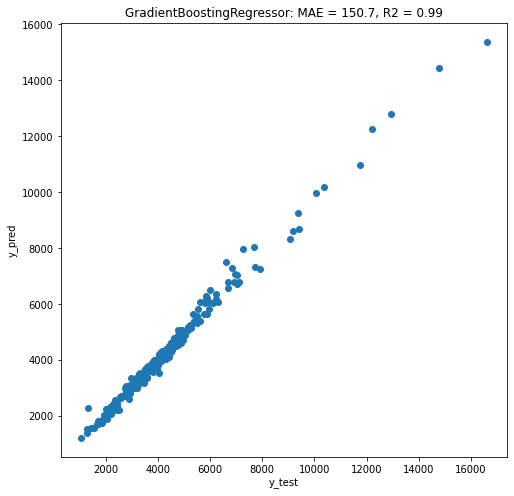

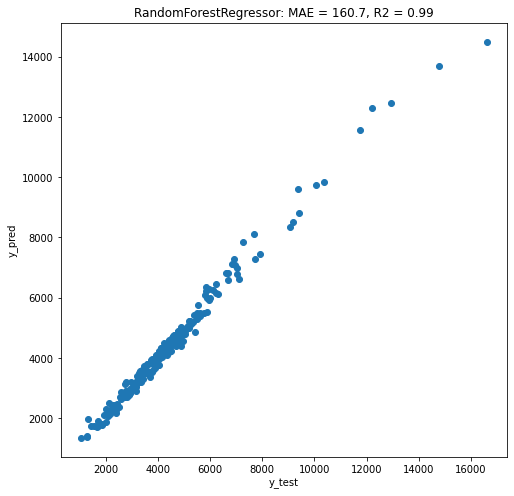

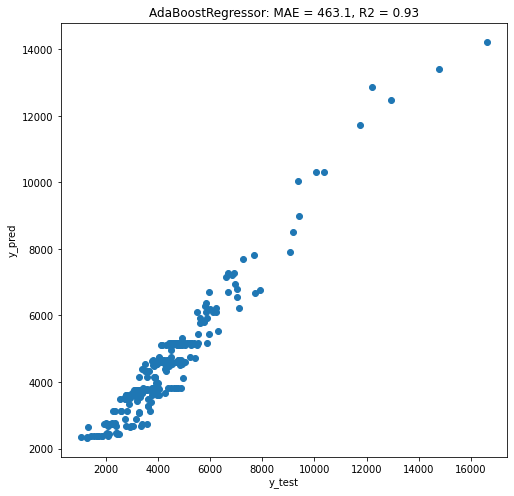

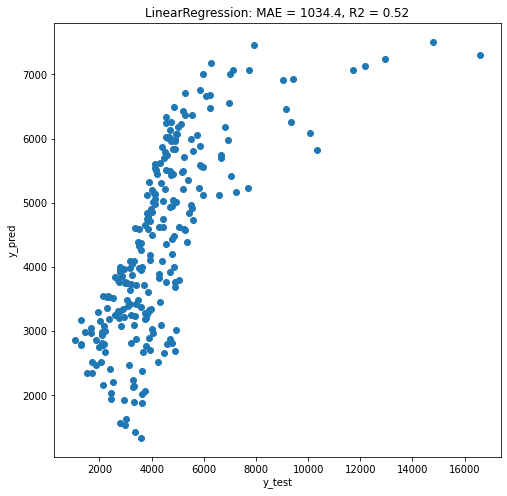

In [7]:
for model_name, score in scores.items():
    plt.figure(figsize=(8,8))
    plt.scatter(y_test, y_preds[model_name])
    plt.title(f"{model_name}: MAE = {score['mae']:.1f}, R2 = {score['r2']:.2f}")
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.show()

In [8]:
def convert_dataframe_schema(df, drop=None, batch_axis=False):
    inputs = []
    nrows = None if batch_axis else 1
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = Int64TensorType([nrows, 1])
        elif v == 'float32':
            t = FloatTensorType([nrows, 1])
        elif v == 'float64':
            t = DoubleTensorType([nrows, 1])
        else:
            raise Exception("Bad type")
        inputs.append((k, t))
    return inputs

In [9]:
best_model = next(iter(scores))

# Write as pickle file
with open('model.pkl', 'wb') as f:
    f.write(pickle.dumps(models[best_model]))

# Write as ONNX file
initial_type = [('float_input', FloatTensorType([None, 5]))]
onnx.save(convert_sklearn(models[best_model], initial_types=initial_type), 'model.onnx')


In [15]:
print(f"Base score of the gradient-boosted trees: {np.mean(y_train)}")
with open("base_score.json", "w") as f:
    f.write(str(np.mean(y_train)))

Base score of the gradient-boosted trees: 4363.578666666666
